In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from collections import Counter

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Initialize VADER analyzer
analyzer = SentimentIntensityAnalyzer()

In [3]:
# read data from "coherence_trial_dataset.csv"
df = pd.read_csv("coherence_trial_dataset.csv")
df

,timestamp,baseline_hrv,hrv,text
0,2025-08-20T10:00:00Z,75,65,"I think I can handle this, but I feel nervous."
1,2025-08-20T10:05:00Z,72,74,I feel confident about the next step.
2,2025-08-20T10:10:00Z,76,60,Maybe we should wait and double-check.
3,2025-08-20T10:15:00Z,80,79,I’m certain this is the right direction.
4,2025-08-20T10:20:00Z,77,65,Not sure if this will work out as planned.
5,2025-08-20T10:25:00Z,74,75,Everything feels balanced and steady.
6,2025-08-20T10:30:00Z,73,68,I might need more time to prepare.
7,2025-08-20T10:35:00Z,78,82,I feel strong and ready to go.
8,2025-08-20T10:40:00Z,76,70,I’m hesitant — maybe we should slow down.
9,2025-08-20T10:45:00Z,75,77,I feel focused and aligned with the goal.


In [4]:
def calculate_coherence_score(hrv, baseline_hrv, text, w=0.8):
    """
    Method 1: VADER + Keyword Boost Coherence Scoring
    
    Combines HRV deviation from baseline with VADER sentiment analysis
    enhanced by domain-specific keyword boosts for coherence assessment.
    
    Args:
        hrv (int): Current HRV value
        baseline_hrv (int): Baseline HRV value  
        text (str): Text snippet to analyze
        w (float): Weight for HRV component (default 0.8, text weight is 1-w)
        
    Returns:
        dict: Contains coherence_score (0-100) and explanation
    """
    
    # Domain-specific keyword dictionary for coherence adjustment
    confidence_words = {
        'confident', 'certain', 'sure', 'clear', 'focused', 'ready', 
        'strong', 'steady', 'balanced', 'aligned', 'determined', 'calm'
    }
    
    uncertainty_words = {
        'nervous', 'unsure', 'maybe', 'hesitant', 'anxious', 'worried',
        'doubt', 'uncertain', 'confused', 'overwhelmed', 'stressed'
    }
    
    # Calculate HRV component using modified power function formula
    # d = |HRV - B| / B (relative deviation)
    # S_HRV = 100 * (max{0, 1 - (d/τ)^p})^q
    # where τ = 0.5 (tolerable gap), p = 2, q = 2 (quadratic penalties)
    tau = 0.5   # tolerable gap threshold (±50%)
    p = 2       # first quadratic penalty exponent
    q = 2       # second quadratic penalty exponent
    
    d = abs(hrv - baseline_hrv) / baseline_hrv  # relative deviation
    inner_term = max(0.0, 1 - (d / tau) ** p)
    hrv_score = 100 * (inner_term ** q)
    
    # VADER sentiment analysis
    vader_scores = analyzer.polarity_scores(text)
    vader_compound = vader_scores['compound']  # Range: -1 to 1
    
    # Convert VADER compound to 0-100 scale (neutral = 50)
    vader_score = (vader_compound + 1) * 50
    
    # Keyword boost analysis
    text_lower = text.lower()
    confidence_boost = sum(2 for word in confidence_words if word in text_lower)
    uncertainty_penalty = sum(2 for word in uncertainty_words if word in text_lower)
    
    # Apply keyword adjustments
    keyword_adjustment = confidence_boost - uncertainty_penalty
    text_score = max(0, min(100, vader_score + keyword_adjustment))
    
    # Combine HRV and text using linear combination with weights
    # Coherence Score = w * S_HRV + (1-w) * S_Text
    coherence_score = w * hrv_score + (1 - w) * text_score
    
    # Generate explanation
    deviation_percent = int(d * 100)  # Convert relative deviation to percentage
    hrv_direction = "above" if hrv > baseline_hrv else "below"
    
    text_sentiment = "positive" if vader_compound > 0.1 else "negative" if vader_compound < -0.1 else "neutral"
    
    explanation_parts = []
    if deviation_percent > 5:
        explanation_parts.append(f"HRV is {deviation_percent}% {hrv_direction} baseline")
    else:
        explanation_parts.append("HRV near baseline")
        
    if confidence_boost > 0:
        explanation_parts.append("text contains confident language")
    elif uncertainty_penalty > 0:
        explanation_parts.append("text contains uncertain/anxious language")
    else:
        explanation_parts.append(f"text shows {text_sentiment} sentiment")
    
    if coherence_score >= 80:
        coherence_level = "high coherence"
    elif coherence_score >= 60:
        coherence_level = "moderate coherence"
    else:
        coherence_level = "low coherence"
        
    explanation = f"{'; '.join(explanation_parts)} → {coherence_level}."
    
    return {
        "coherence_score": coherence_score,
        "explanation": explanation,
        "components": {
            "hrv_score": round(hrv_score, 1),
            "text_score": round(text_score, 1), 
            "vader_compound": round(vader_compound, 3),
            "keyword_adjustment": keyword_adjustment,
            "weight_hrv": w,
            "weight_text": 1 - w
        }
    }

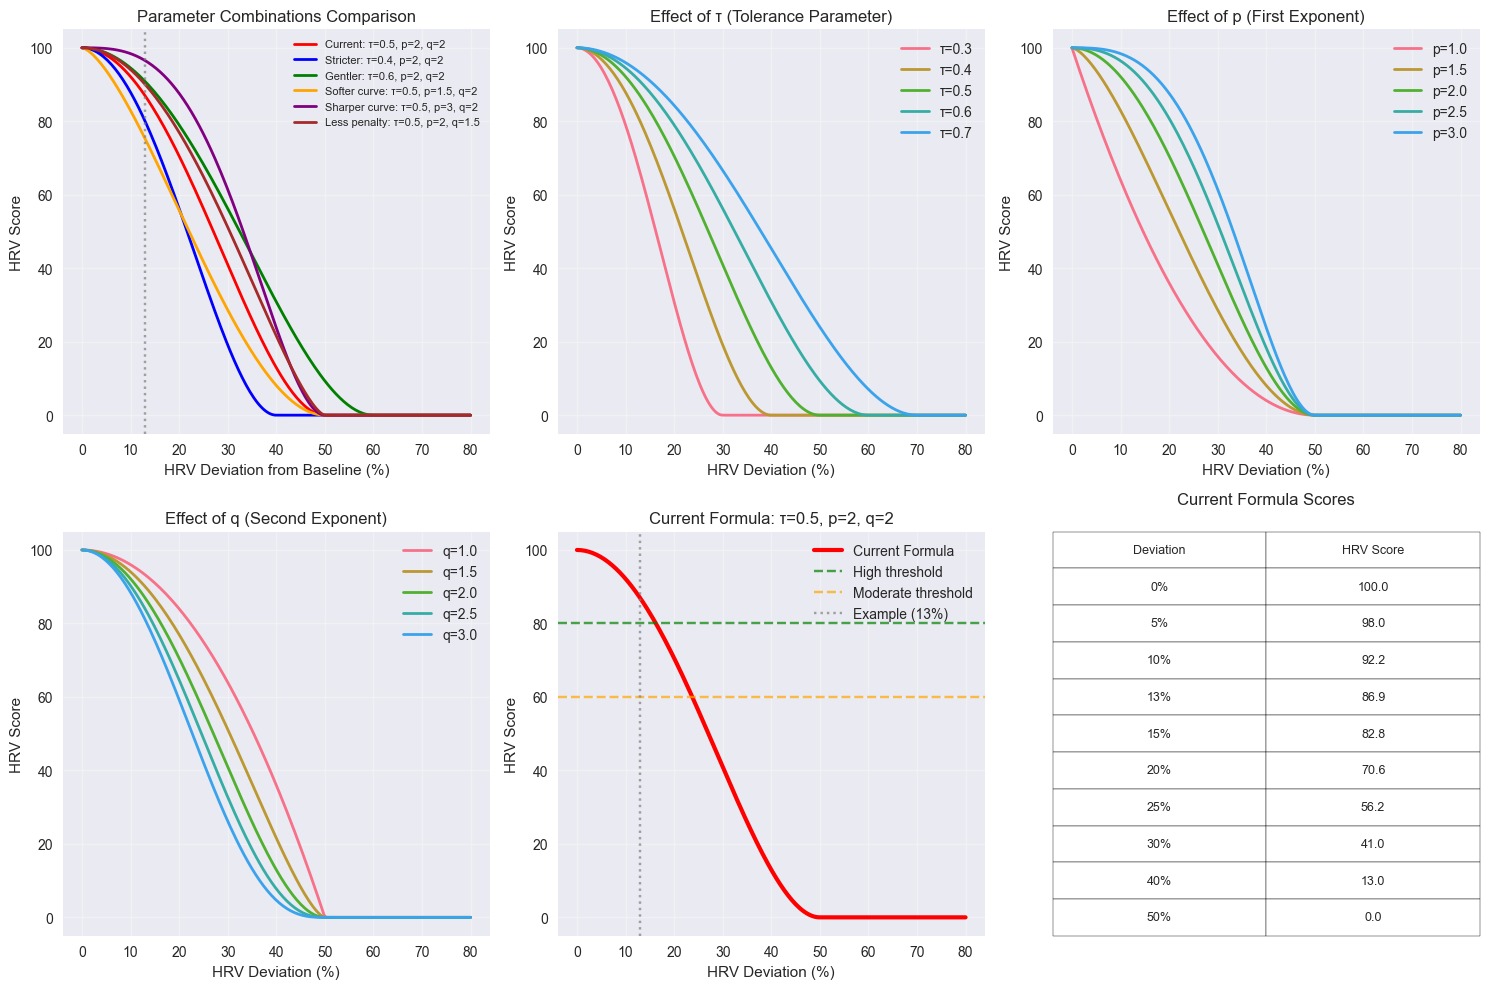

PARAMETER ANALYSIS:
τ (Tolerance): Controls where score becomes zero
  - τ=0.3: Zero at 30% deviation (stricter)
  - τ=0.5: Zero at 50% deviation (current)
  - τ=0.7: Zero at 70% deviation (gentler)

p (First Exponent): Controls curve shape in main region
  - p=1.0: Linear decay
  - p=2.0: Quadratic decay (current)
  - p=3.0: Cubic decay (more curved)

q (Second Exponent): Controls overall curve steepness
  - q=1.0: Gentler overall penalty
  - q=2.0: Moderate penalty (current)
  - q=3.0: Steeper penalty


In [5]:
# Visualize HRV scoring with different parameter combinations
def plot_hrv_parameter_analysis():
    """Explore different parameter combinations for the HRV scoring formula"""
    
    # Generate relative deviations from 0% to 80%
    deviations = np.linspace(0, 0.8, 200)  # 0% to 80% deviation
    
    # Parameter combinations to test
    param_sets = [
        (0.5, 2, 2, "Current: τ=0.5, p=2, q=2"),
        (0.4, 2, 2, "Stricter: τ=0.4, p=2, q=2"),
        (0.6, 2, 2, "Gentler: τ=0.6, p=2, q=2"),
        (0.5, 1.5, 2, "Softer curve: τ=0.5, p=1.5, q=2"),
        (0.5, 3, 2, "Sharper curve: τ=0.5, p=3, q=2"),
        (0.5, 2, 1.5, "Less penalty: τ=0.5, p=2, q=1.5"),
    ]
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    
    # Main comparison plot
    plt.subplot(2, 3, 1)
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    for i, (tau, p, q, label) in enumerate(param_sets):
        scores = []
        for d in deviations:
            inner_term = max(0.0, 1 - (d / tau) ** p)
            score = 100 * (inner_term ** q)
            scores.append(score)
        plt.plot(deviations * 100, scores, color=colors[i], linewidth=2, label=label)
    
    plt.xlabel('HRV Deviation from Baseline (%)')
    plt.ylabel('HRV Score')
    plt.title('Parameter Combinations Comparison')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.axvline(x=13, color='gray', linestyle=':', alpha=0.7, label='Our example (13%)')
    
    # Individual parameter effect plots
    # Effect of τ (tolerance)
    plt.subplot(2, 3, 2)
    tau_values = [0.3, 0.4, 0.5, 0.6, 0.7]
    for tau in tau_values:
        scores = []
        for d in deviations:
            inner_term = max(0.0, 1 - (d / tau) ** 2)
            score = 100 * (inner_term ** 2)
            scores.append(score)
        plt.plot(deviations * 100, scores, linewidth=2, label=f'τ={tau}')
    plt.xlabel('HRV Deviation (%)')
    plt.ylabel('HRV Score')
    plt.title('Effect of τ (Tolerance Parameter)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Effect of p (first exponent)
    plt.subplot(2, 3, 3)
    p_values = [1.0, 1.5, 2.0, 2.5, 3.0]
    for p in p_values:
        scores = []
        for d in deviations:
            inner_term = max(0.0, 1 - (d / 0.5) ** p)
            score = 100 * (inner_term ** 2)
            scores.append(score)
        plt.plot(deviations * 100, scores, linewidth=2, label=f'p={p}')
    plt.xlabel('HRV Deviation (%)')
    plt.ylabel('HRV Score')
    plt.title('Effect of p (First Exponent)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Effect of q (second exponent)
    plt.subplot(2, 3, 4)
    q_values = [1.0, 1.5, 2.0, 2.5, 3.0]
    for q in q_values:
        scores = []
        for d in deviations:
            inner_term = max(0.0, 1 - (d / 0.5) ** 2)
            score = 100 * (inner_term ** q)
            scores.append(score)
        plt.plot(deviations * 100, scores, linewidth=2, label=f'q={q}')
    plt.xlabel('HRV Deviation (%)')
    plt.ylabel('HRV Score')
    plt.title('Effect of q (Second Exponent)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Detailed view of our current formula
    plt.subplot(2, 3, 5)
    tau, p, q = 0.5, 2, 2
    scores = []
    for d in deviations:
        inner_term = max(0.0, 1 - (d / tau) ** p)
        score = 100 * (inner_term ** q)
        scores.append(score)
    plt.plot(deviations * 100, scores, 'red', linewidth=3, label='Current Formula')
    plt.xlabel('HRV Deviation (%)')
    plt.ylabel('HRV Score')
    plt.title('Current Formula: τ=0.5, p=2, q=2')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='High threshold')
    plt.axhline(y=60, color='orange', linestyle='--', alpha=0.7, label='Moderate threshold')
    plt.axvline(x=13, color='gray', linestyle=':', alpha=0.7, label='Example (13%)')
    plt.legend()
    
    # Score table for key deviations
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    # Calculate scores for key deviations with current parameters
    key_deviations = [0, 5, 10, 13, 15, 20, 25, 30, 40, 50]
    current_scores = []
    for dev in key_deviations:
        d = dev / 100
        inner_term = max(0.0, 1 - (d / 0.5) ** 2)
        score = 100 * (inner_term ** 2)
        current_scores.append(score)
    
    # Create table
    table_data = []
    for i, dev in enumerate(key_deviations):
        table_data.append([f"{dev}%", f"{current_scores[i]:.1f}"])
    
    table = plt.table(cellText=table_data, 
                     colLabels=['Deviation', 'HRV Score'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    plt.title('Current Formula Scores', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print("PARAMETER ANALYSIS:")
    print("=" * 50)
    print("τ (Tolerance): Controls where score becomes zero")
    print("  - τ=0.3: Zero at 30% deviation (stricter)")
    print("  - τ=0.5: Zero at 50% deviation (current)")
    print("  - τ=0.7: Zero at 70% deviation (gentler)")
    print()
    print("p (First Exponent): Controls curve shape in main region")
    print("  - p=1.0: Linear decay")
    print("  - p=2.0: Quadratic decay (current)")
    print("  - p=3.0: Cubic decay (more curved)")
    print()
    print("q (Second Exponent): Controls overall curve steepness")
    print("  - q=1.0: Gentler overall penalty")
    print("  - q=2.0: Moderate penalty (current)")
    print("  - q=3.0: Steeper penalty")

plot_hrv_parameter_analysis()

In [6]:
# Test the final coherence scoring implementation
print("FINAL COHERENCE SCORING TEST")
print("=" * 40)

# Test on our key example
test_result = calculate_coherence_score(65, 75, "I think I can handle this, but I feel nervous.")
print("Key Example Test:")
print(f"  HRV: 65, Baseline: 75 (13% below)")
print(f"  Text: 'I think I can handle this, but I feel nervous.'")
print(f"  HRV Score: {test_result['components']['hrv_score']}")
print(f"  Text Score: {test_result['components']['text_score']}")
print(f"  Final Coherence Score: {test_result['coherence_score']:.2f}")
print(f"  Explanation: {test_result['explanation']}")
print()

# JSON output example
import json
json_result = {
    "coherence_score": test_result['coherence_score'], 
    "explanation": test_result['explanation']
}
print("JSON Output Example:")
print(json.dumps(json_result, indent=2))

FINAL COHERENCE SCORING TEST
Key Example Test:
  HRV: 65, Baseline: 75 (13% below)
  Text: 'I think I can handle this, but I feel nervous.'
  HRV Score: 86.3
  Text Score: 28.4
  Final Coherence Score: 74.71
  Explanation: HRV is 13% below baseline; text contains uncertain/anxious language → moderate coherence.

JSON Output Example:
{
  "coherence_score": 74.70776543209877,
  "explanation": "HRV is 13% below baseline; text contains uncertain/anxious language \u2192 moderate coherence."
}


In [12]:
# compare different weight choices between 0.6 to 1, with a step of 0.05
weights = [round(w, 2) for w in np.arange(0.6, 1.05, 0.05)]
results = []

for w in weights:
    test_result = calculate_coherence_score(65, 75, "I think I can handle this, but I feel nervous.", w=w)
    results.append((w, test_result['coherence_score']))

# Display the results
for w, coherence_score in results:
    print(f"Weight: {w}, Coherence Score: {coherence_score}")


Weight: 0.6, Coherence Score: 63.13207407407407
Weight: 0.65, Coherence Score: 66.02599691358024
Weight: 0.7, Coherence Score: 68.91991975308642
Weight: 0.75, Coherence Score: 71.81384259259258
Weight: 0.8, Coherence Score: 74.70776543209877
Weight: 0.85, Coherence Score: 77.60168827160493
Weight: 0.9, Coherence Score: 80.49561111111112
Weight: 0.95, Coherence Score: 83.38953395061728
Weight: 1.0, Coherence Score: 86.28345679012345


In [27]:
# Apply to entire dataset
results = []
for idx, row in df.iterrows():
    result = calculate_coherence_score(row['hrv'], row['baseline_hrv'], row['text'])
    result['index'] = idx
    result['timestamp'] = row['timestamp']
    result['hrv'] = row['hrv']
    result['baseline_hrv'] = row['baseline_hrv']
    result['text'] = row['text']
    results.append(result)

# Display results in a formatted table
# for result in results:
#     print(f"Sample {result['index'] + 1}:")
#     print(f"  HRV: {result['hrv']} (baseline: {result['baseline_hrv']})")
#     print(f"  Text: \"{result['text']}\"")
#     print(f"  Score: {result['coherence_score']}/100")
#     print(f"  Explanation: {result['explanation']}")
#     print(f"  Components: HRV={result['components']['hrv_score']:.1f}, Text={result['components']['text_score']:.1f}, VADER={result['components']['vader_compound']:.3f}")
#     print()

# Summary statistics
scores = [r['coherence_score'] for r in results]
print(f"Summary Statistics:")
print(f"  Mean Coherence Score: {np.mean(scores):.1f}")
print(f"  Median Coherence Score: {np.median(scores):.1f}")
print(f"  Min/Max Scores: {min(scores)}/{max(scores)}")
print(f"  Standard Deviation: {np.std(scores):.1f}")

# Create DataFrame for easier analysis
results_df = pd.DataFrame([
    {
        'timestamp': r['timestamp'],
        'hrv': r['hrv'],
        'baseline_hrv': r['baseline_hrv'], 
        'text': r['text'],
        'coherence_score': r['coherence_score'],
        'hrv_score': r['components']['hrv_score'],
        'text_score': r['components']['text_score'],
        'vader_compound': r['components']['vader_compound'],
        'keyword_adjustment': r['components']['keyword_adjustment']
    } for r in results
])

print(f"\nResults DataFrame:")
print(results_df[['coherence_score', 'hrv_score', 'text_score', 'vader_compound']].round(2))

Summary Statistics:
  Mean Coherence Score: 85.0
  Median Coherence Score: 88.9
  Min/Max Scores: 63.748755764612/96.12874939235537
  Standard Deviation: 10.5

Results DataFrame:
   coherence_score  hrv_score  text_score  vader_compound
0            74.71       86.3        28.4           -0.39
1            94.85       99.4        76.7            0.49
2            63.75       67.7        48.0            0.00
3            93.03       99.9        65.7            0.27
4            73.20       81.5        39.9           -0.24
5            90.68       99.9        54.0            0.00
6            87.03       96.3        50.0            0.00
7            96.13       97.9        89.0            0.70
8            82.76       95.1        33.5           -0.25
9            94.16       99.4        73.1            0.38


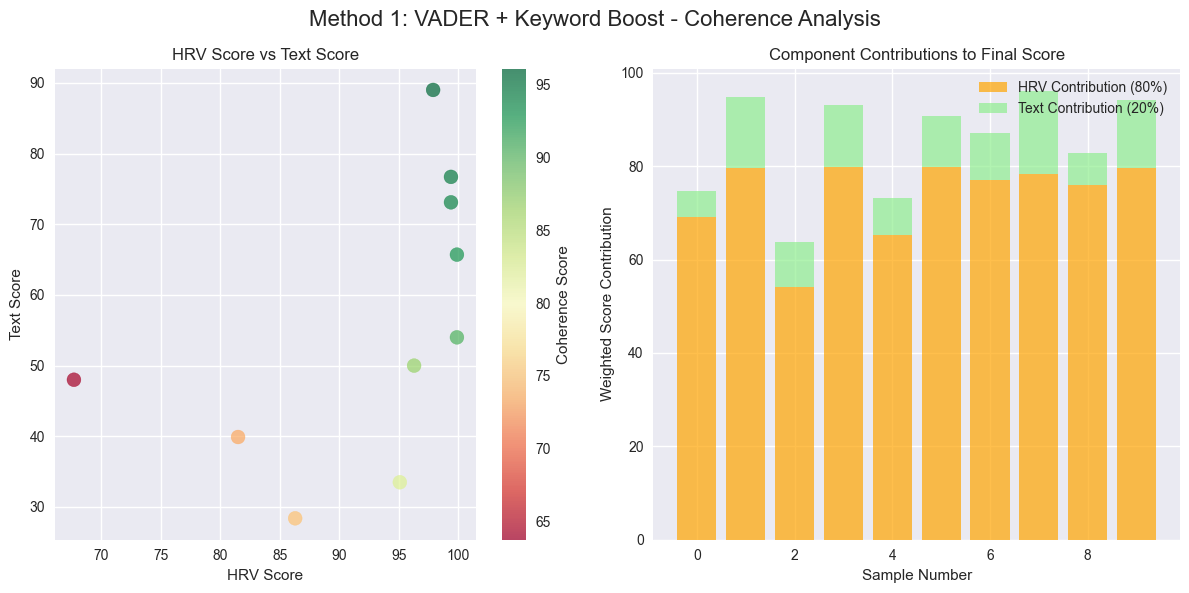


METHOD 1 INSIGHTS:
High Coherence Samples (≥80): 7
  Examples:
    - Score 94.84593491845754: "I feel confident about the next step."
    - Score 93.03203125: "I’m certain this is the right direction."
    - Score 90.68316905537999: "Everything feels balanced and steady."
    - Score 87.0257312768069: "I might need more time to prepare."
    - Score 96.12874939235537: "I feel strong and ready to go."
    - Score 82.76080370776775: "I’m hesitant — maybe we should slow down."
    - Score 94.1635361580247: "I feel focused and aligned with the goal."

Low Coherence Samples (<50): 0


In [30]:
# Create visualizations for Method 1 results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Method 1: VADER + Keyword Boost - Coherence Analysis', fontsize=16)

# 1. HRV vs Text Score Components  
scatter = axes[0].scatter(results_df['hrv_score'], results_df['text_score'], 
                         c=results_df['coherence_score'], cmap='RdYlGn', s=100, alpha=0.7)
axes[0].set_title('HRV Score vs Text Score')
axes[0].set_xlabel('HRV Score')
axes[0].set_ylabel('Text Score')
plt.colorbar(scatter, ax=axes[0], label='Coherence Score')

# 2. Component Contributions
component_data = results_df[['hrv_score', 'text_score']].values
labels = ['HRV Component', 'Text Component']
x_pos = range(len(results_df))

# Weighted contributions (80% HRV, 20% Text based on current w=0.8)
current_w = 0.8  # Get from the function default
hrv_contrib = results_df['hrv_score'] * current_w
text_contrib = results_df['text_score'] * (1 - current_w)

axes[1].bar(x_pos, hrv_contrib, alpha=0.7, label=f'HRV Contribution ({current_w*100:.0f}%)', color='orange')
axes[1].bar(x_pos, text_contrib, bottom=hrv_contrib, alpha=0.7, 
            label=f'Text Contribution ({(1-current_w)*100:.0f}%)', color='lightgreen')
axes[1].set_title('Component Contributions to Final Score')
axes[1].set_xlabel('Sample Number')
axes[1].set_ylabel('Weighted Score Contribution')
axes[1].legend()

plt.tight_layout()
plt.show()

# Print some insights
print("\n" + "="*60)
print("METHOD 1 INSIGHTS:")
print("="*60)

high_coherence = results_df[results_df['coherence_score'] >= 80]
low_coherence = results_df[results_df['coherence_score'] < 50]

print(f"High Coherence Samples (≥80): {len(high_coherence)}")
if len(high_coherence) > 0:
    print("  Examples:")
    for idx, row in high_coherence.iterrows():
        print(f"    - Score {row['coherence_score']}: \"{row['text']}\"")

print(f"\nLow Coherence Samples (<50): {len(low_coherence)}")
if len(low_coherence) > 0:
    print("  Examples:")
    for idx, row in low_coherence.iterrows():
        print(f"    - Score {row['coherence_score']}: \"{row['text']}\"")

In [35]:
def process_coherence_batch(data_list):
    """
    Batch processing function for multiple coherence events.
    
    Args:
        data_list (list): List of dicts with keys 'hrv', 'baseline_hrv', 'text'
        
    Returns:
        list: List of coherence score results in JSON format
    """
    batch_results = []
    
    for i, data in enumerate(data_list):
        try:
            result = calculate_coherence_score(
                data['hrv'], 
                data['baseline_hrv'], 
                data['text']
            )
            
            # Clean up for JSON output - remove components for cleaner API response
            json_result = {
                "coherence_score": result["coherence_score"],
                "explanation": result["explanation"]
            }
            batch_results.append(json_result)
            
        except Exception as e:
            # Handle any errors gracefully
            batch_results.append({
                "coherence_score": 0,
                "explanation": f"Error processing sample {i+1}: {str(e)}"
            })
    
    return batch_results
# Example from the task description
example_data = {
    'hrv': 65,
    'baseline_hrv': 75,
    'text': "I think I can handle this, but I feel a little nervous."
}

result = calculate_coherence_score(example_data['hrv'], example_data['baseline_hrv'], example_data['text'])
json_output = {
    "coherence_score": result["coherence_score"],
    "explanation": result["explanation"]
}

import json
print("Example JSON Output:")
print(json.dumps(json_output, indent=2))

# Convert our dataset to batch format and process a few samples
batch_data = []
for idx in range(len(df)):  # Process first 3 samples
    batch_data.append({
        'hrv': int(df.iloc[idx]['hrv']),
        'baseline_hrv': int(df.iloc[idx]['baseline_hrv']),
        'text': df.iloc[idx]['text']
    })

batch_results = process_coherence_batch(batch_data)


Example JSON Output:
{
  "coherence_score": 75.64376543209877,
  "explanation": "HRV is 13% below baseline; text contains uncertain/anxious language \u2192 moderate coherence."
}


In [36]:
batch_results

[{'coherence_score': 74.70776543209877,
  'explanation': 'HRV is 13% below baseline; text contains uncertain/anxious language → moderate coherence.'},
 {'coherence_score': 94.84593491845754,
  'explanation': 'HRV near baseline; text contains confident language → high coherence.'},
 {'coherence_score': 63.748755764612,
  'explanation': 'HRV is 21% below baseline; text contains uncertain/anxious language → moderate coherence.'},
 {'coherence_score': 93.03203125,
  'explanation': 'HRV near baseline; text contains confident language → high coherence.'},
 {'coherence_score': 73.20010705614347,
  'explanation': 'HRV is 15% below baseline; text contains confident language → moderate coherence.'},
 {'coherence_score': 90.68316905537999,
  'explanation': 'HRV near baseline; text contains confident language → high coherence.'},
 {'coherence_score': 87.0257312768069,
  'explanation': 'HRV is 6% below baseline; text shows neutral sentiment → high coherence.'},
 {'coherence_score': 96.1287493923553